In [1]:
# sujitjit - 50247206
# gautamav - 50245840

### This block of the notebook was primarily used for collecting and saving tweets 

initialize_twitter <- function() {
  ### This function was used to initiate the use twitterREST API by using oauth 
    
  # This has been hashed for security reasons
  library("twitteR")
  api_key = 'IOaRMQiU3FyKKMqWV6698NE**'
  api_secret = 'M0Ek6S9pyEUGiJOFdV5GrC6WAdU0fTfOAh0bJjDYborOOajt**'
  access_token = '963910109788295170-kTqCFtlUeYnkC6ppDecdUp3WQV8TT**'
  access_token_secret = 'R60XHcappkg5f2unftlx4dwcXYsyxdFWx2HZ8qiiN22**'
  setup_twitter_oauth(api_key,api_secret,access_token,access_token_secret)
}

collect_tweets <- function(nmax){
  ### once the connection has been authenticated and initialized, we are now ready to query the REST API and 
  ### collect tweets 
  ### We used combination of multiple tags for collecting data. 2 primary combinations were used
  ### 1) "flu OR #flu OR #influenza OR #fluseason OR #Flu OR #Fluseason"  (~ 17,000 tweets)
  ### 2)  #Flu2018 OR FluGov OR CDCFlu OR #CDCFl OR #H1N1 OR #Influenza OR FluData OR #FluData (~18,000 tweets)
  ### Total of 35000 tweets were collected but the unique tweets were close to 17,500 
    
  searchResults = searchTwitter("flu OR #flu OR #influenza OR #fluseason OR #Flu OR #Fluseason", n=nmax) 
  # 900 tweets can be collected at once 
  tweetS = twListToDF(searchResults[1])
  tweetS = tweetS[FALSE,]
  finalData = as.data.frame(matrix(nrow = nmax, ncol = 2))
  colnames(finalData) = c("id","Location")
  # we are only interestd in id and location of the tweets because id is what helps uniquely identify a tweet and 
  # location is something we need for the heatmap
    
  for (i in 1:nmax){
    tweet = twListToDF(searchResults[i]) # convert tweet to dataframe 
    tempUser = getUser(tweet$screenName) # username
    tempLocn = tempUser$getLocation()   # User location is used for location because tweet locn was rarely available
    finalData[i,1] = tweet$id
    finalData[i,2] = tempLocn
    #    print(tweet$text)
    if(i%%100==0) # this is just to keep track of how many tweets have been processed   
      print(i)
  }
  
  write.table(finalData, "Data/flu.csv", sep = ",", 
              col.names = F, append = T)
}



initialize_twitter() # intialize API  
collect_tweets(900) # collect tweets 

# PS : The block may throw warnings while dealing with chinese characters and other anomalous characters since we
# are collecting tweets from all over the world, there are all kinds of unexpected characters that throw warnings 
# while being processed 

[1] "Using direct authentication"
[1] 100
[1] 200
[1] 300
[1] 400
[1] 500
[1] 600
[1] 700
[1] 800
[1] 900


In [4]:
get_location_index <- function(userLocn) {
  # function checks for state name in the given string   
    
  # logic 1 : separate the strings using <,> as delimitter because many tweets had locations as city, state
  userLocn = strsplit(userLocn, ",") 
    
  x = state.name # holds all the names of the US states 
  y = state.abb  # holds all the abbrevations of the US states 
  
  # this for loop goes through every <','> delimitted word in the passed string and checks if it is in 
  # x or y i.e us state name or abbrevation 
  # if a match is found then return the index of the respective US state (1-50)
  for (i in userLocn){
      #print(i)
    for (j in i){
    #print(j)
      s = trimws(j, which = "both") # trims white space
      
      index = match(s,x)
      if(is.na(index)==FALSE)
        return (index)
      
      index = match(s,y)
      if(is.na(index)==FALSE)
        return (index)
    }
  }
    # logic 2 : separate the strings using <' '> as delimitter because many tweets did not have <','> as delimitter
    # and it was easy to miss out on states because a string like < city state or buffalo ny wont be separated at 
    # all and we would miss out on this tweet. So it was essential to also check for tweets using space as a delimiter
    
    userLocn = as.character(userLocn)
    userLocn = strsplit(userLocn, ' ')
    for (i in userLocn){
      #print(i)
        for (j in i){
        #print(j)
          s = trimws(j, which = "both") # trims white space

          index = match(s,x)
          if(is.na(index)==FALSE)
            return (index)

          index = match(s,y)
          if(is.na(index)==FALSE)
            return (index)
        }
    }
 
    
    
      
  return (-1)  #return -1 if no matching state is found 
}

# PS : The block may throw warnings while dealing with chinese characters and other anomalous characters since we
# are collecting tweets from all over the world, there are all kinds of unexpected characters that throw warnings 
# while being processed 

In [5]:
### This block of notebook reads the location from the collected tweets and generates a csv file that has 3 columns
### 1) state name 2) frequency of tweets 3) category based on tweets frequency
### the category is decided by subdividing the frequency range into categories 
### example: 
# if frequency is betweeen 1 to 100, category is 1,
# if frequency is betweeen 101 to 200, category is 2,
# etc

data1 = read.csv("Data/flu_combined.csv")
data1 = unique(data1)
lengths(data1) # unique tweets are roughly 50 to 60 % of the original tweets in all the 3 files
# the number of unique tweets was ~17,000 to 18,000 which is almost half the ~36,000 tweets initially collected

V = vector (mode = 'integer', length = 50) # this will store the frequency of all the states 


Locations = data1$Location # LOCATION COLUMN 
count = 0

for (i in Locations){
    index = get_location_index(i)
    if(index!=-1)
        V[index] = V[index]+1;
    
    count = count + 1
    if(count %% 1000 == 0) # this is just to keep track of how many iterations we are through 
        print(count)
}

write("State, Frequency", file = "output_tag_combined.csv") # generate the csv with 3 columns 


for (i in 1:50){
    USstate = state.name[i]
    frequency = V[i]
    category = as.integer(frequency / 30) # division by 30 was ideal considering the frequency was in the range 
    # between 0 to 450 for all the 3 heatmaps
    line = paste(USstate, ',' , frequency, ',', category) 
     write(line , file = "output_tag_combined.csv", append = TRUE);
    
}


# PS : The block may throw warnings while dealing with chinese characters and other anomalous characters since we
# are collecting tweets from all over the world, there are all kinds of unexpected characters that throw warnings 
# while being processed 

id Location 
   17325    17325

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000


Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input str

[1] 11000


Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input str

[1] 12000


Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input str

[1] 13000


Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”

[1] 14000


Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input str

[1] 15000


Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”

[1] 16000


Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input str

[1] 17000


Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”Warning message in strsplit(userLocn, ","):
“input string 1 is invalid in this locale”

In [6]:
generateHeatmap <- function(filePath,option)
    {
        # importing required libraries
        library(ggplot2)  
        library(maps) 

        # importing data from csv file
        twitter_data<- read.csv(filePath)

        # extracting states data from maps library
        state_data <-map_data("state")

        # creating the region column in the imported dataset  
        twitter_data$region = tolower(twitter_data$state)

        # merging the dataframe from library and local file mapping it by region
        twitter_data_map <- merge(state_data, twitter_data, by = "region", all.x = T)

        # ordering the resultant dataset by column name -> order
        twitter_data_map <-twitter_data_map[order(twitter_data_map$order), ]

        # implementation of heatmap goes here
        ggplot(twitter_data_map, aes(x=long,y=lat,group=group)) + # plotting the map based on merged data, grouping data by groups
            geom_polygon(aes(fill=category)) + # using polygon fill for each states depending on ACTIVITY.LEVEL
            geom_path() + # to show boundaries of each state
            scale_fill_gradient2(low = "white",mid="green", high = "red") + # manual color fill to discrete scale
            coord_map() + # mapping as per coordinate
            ggtitle(option) # defining title for the maps




    }



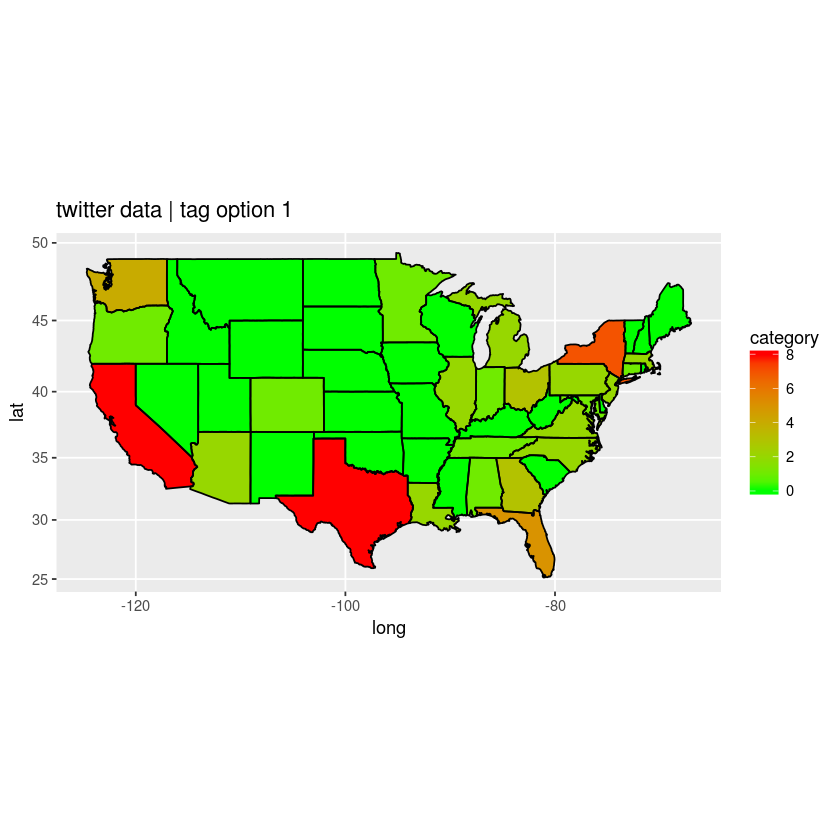

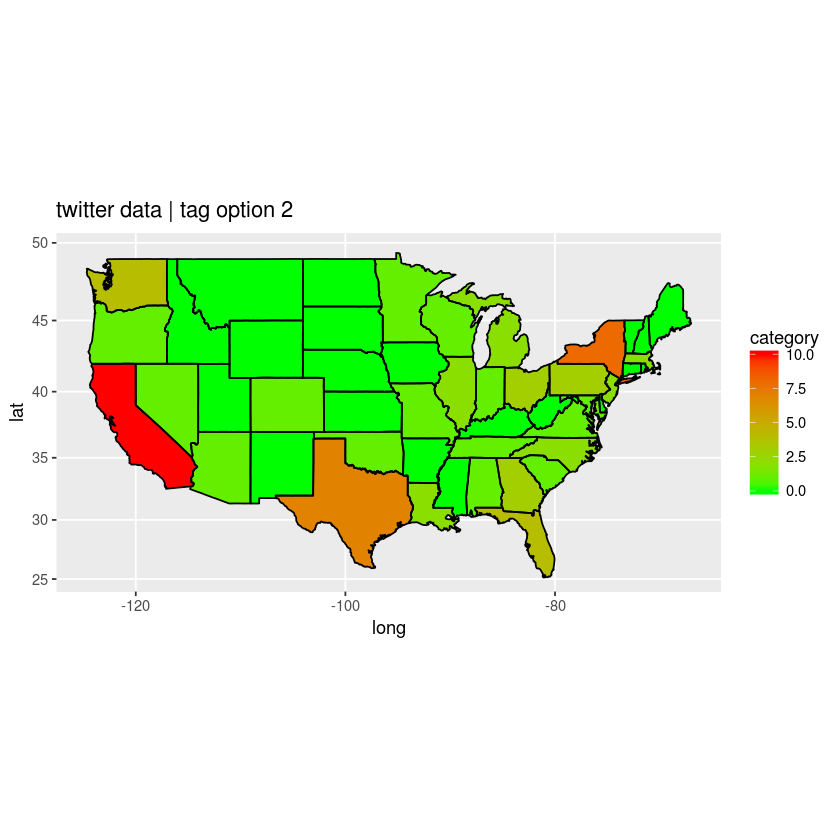

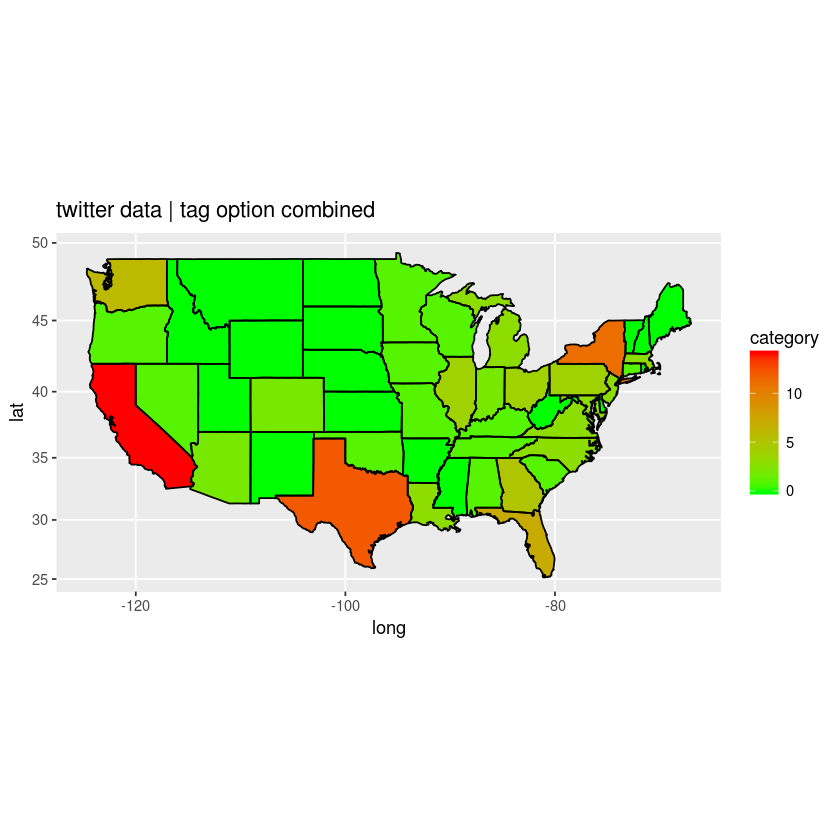

In [7]:
generateHeatmap("Data/output_tag_1.csv","twitter data | tag option 1")
generateHeatmap("Data/output_tag_2.csv","twitter data | tag option 2")
generateHeatmap("Data/output_tag_combined.csv","twitter data | tag option combined")

## Note: Please compile the upper block before running this block in the python notebook

